In [1]:
import sys
sys.path.append("/storage/vbutoi/projects/")
sys.path.append("/storage/vbutoi/libraries/")
from ionpy.analysis import ResultsLoader
import pathlib
import seaborn as sns
import pandas as pd
sns.set_context('talk')
sns.set_style("darkgrid")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage',
))

# Results loader object does everything
rs = ResultsLoader()
root = "/storage/vbutoi/scratch/ESE"

In [2]:
path_list = [
    # "/storage/vbutoi/scratch/ESE/calibration/09_11_24_ISLES_3D_LTS_AndrewsLevelsBIG",
    # "/storage/vbutoi/scratch/ESE/calibration/09_12_24_ISLES_3D_LTS_LRandCapSweep",
    "/storage/vbutoi/scratch/ESE/calibration/09_16_24_ISLES_3D_LTS_wAug",
    # "/storage/vbutoi/scratch/ESE/calibration/09_17_24_ISLES_3D_LTS_CE_wAug",
    # "/storage/vbutoi/scratch/ESE/calibration/09_17_24_ISLES_3D_LTS_SoftDice_wAug",
]

df_list = []
for path in path_list:
    try:
        dfc = rs.load_configs(
            path,
            properties=False,
        )
        df = rs.load_metrics(dfc)
        df_list.append(df)
    except Exception as e:
        print(e)
df = pd.concat(df_list)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
# Only keep the epochs every 10 to reduce the number of points
df = df[df['epoch'] % 10 == 0]

In [4]:
for ikey in df.keys():
    print(ikey)

phase
epoch
loss
area_estimation_error
dice_score
added_noise_max_sigma
added_noise_probability
bias_field_probability
gamma_scaling_max
gamma_scaling_probability
normalize_max_scale
normalize_min_quantile
use_mask
data
iters_per_epoch
preload
train_splits
val_splits
version
batch_size
num_workers
pin_memory
seed
torch_compile
torch_mixed_precision
loss_func
batch_reduction
from_logits
model
dims
filters
image_channels
img_channels
num_classes
optim
lr
base_checkpoint
base_pretrained_dir
base_pt_select_metric
epochs
eval_freq
path


In [5]:
# def calibrator(path):
#     return str(path).split('_')[-2].split('/')[0]

# # def calibrator(path):
# #     return str(path).split('_')[-3]
    
# df.augment(calibrator)

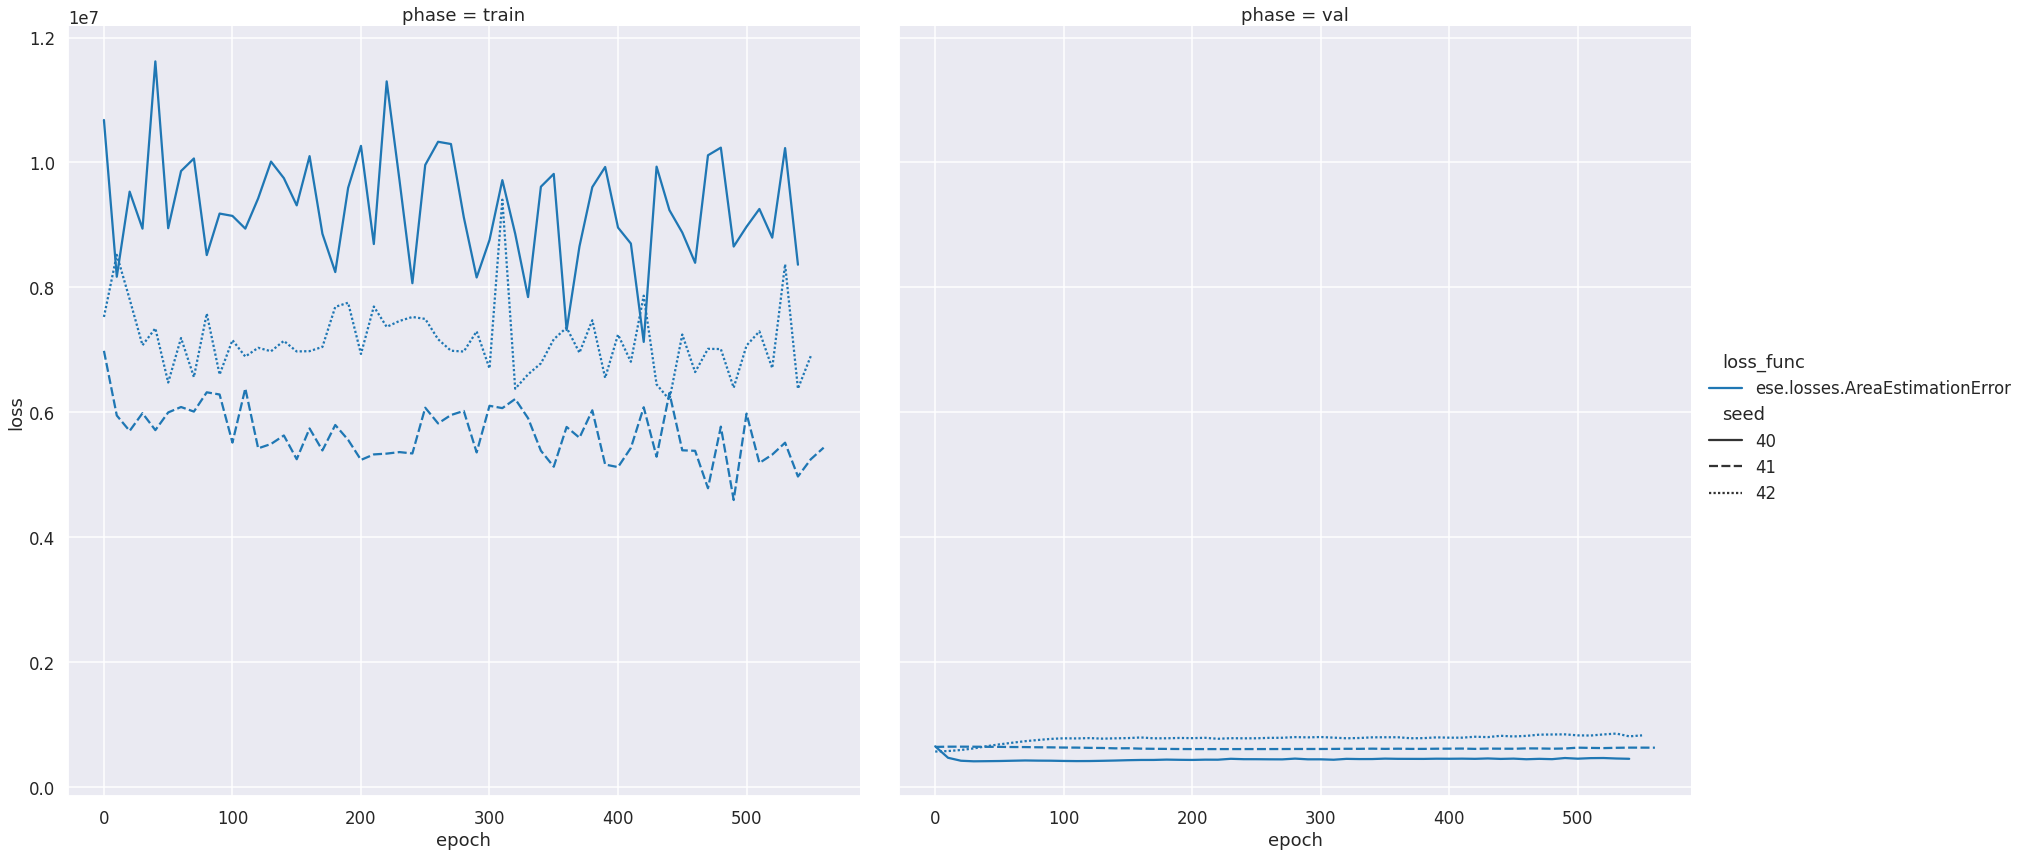

In [6]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='loss',
    hue='loss_func',
    style='seed',
    # hue='filters',
    # style='lr',
    col='phase',
    kind='line',
    height=12,
)

# Set column spacing
g.fig.subplots_adjust(wspace=0.05)
# g.set(ylim=(0.0, 0.25))

In [7]:
df.select(loss_func='ese.losses.PixelCELoss')['path'].unique()

array([], dtype=object)

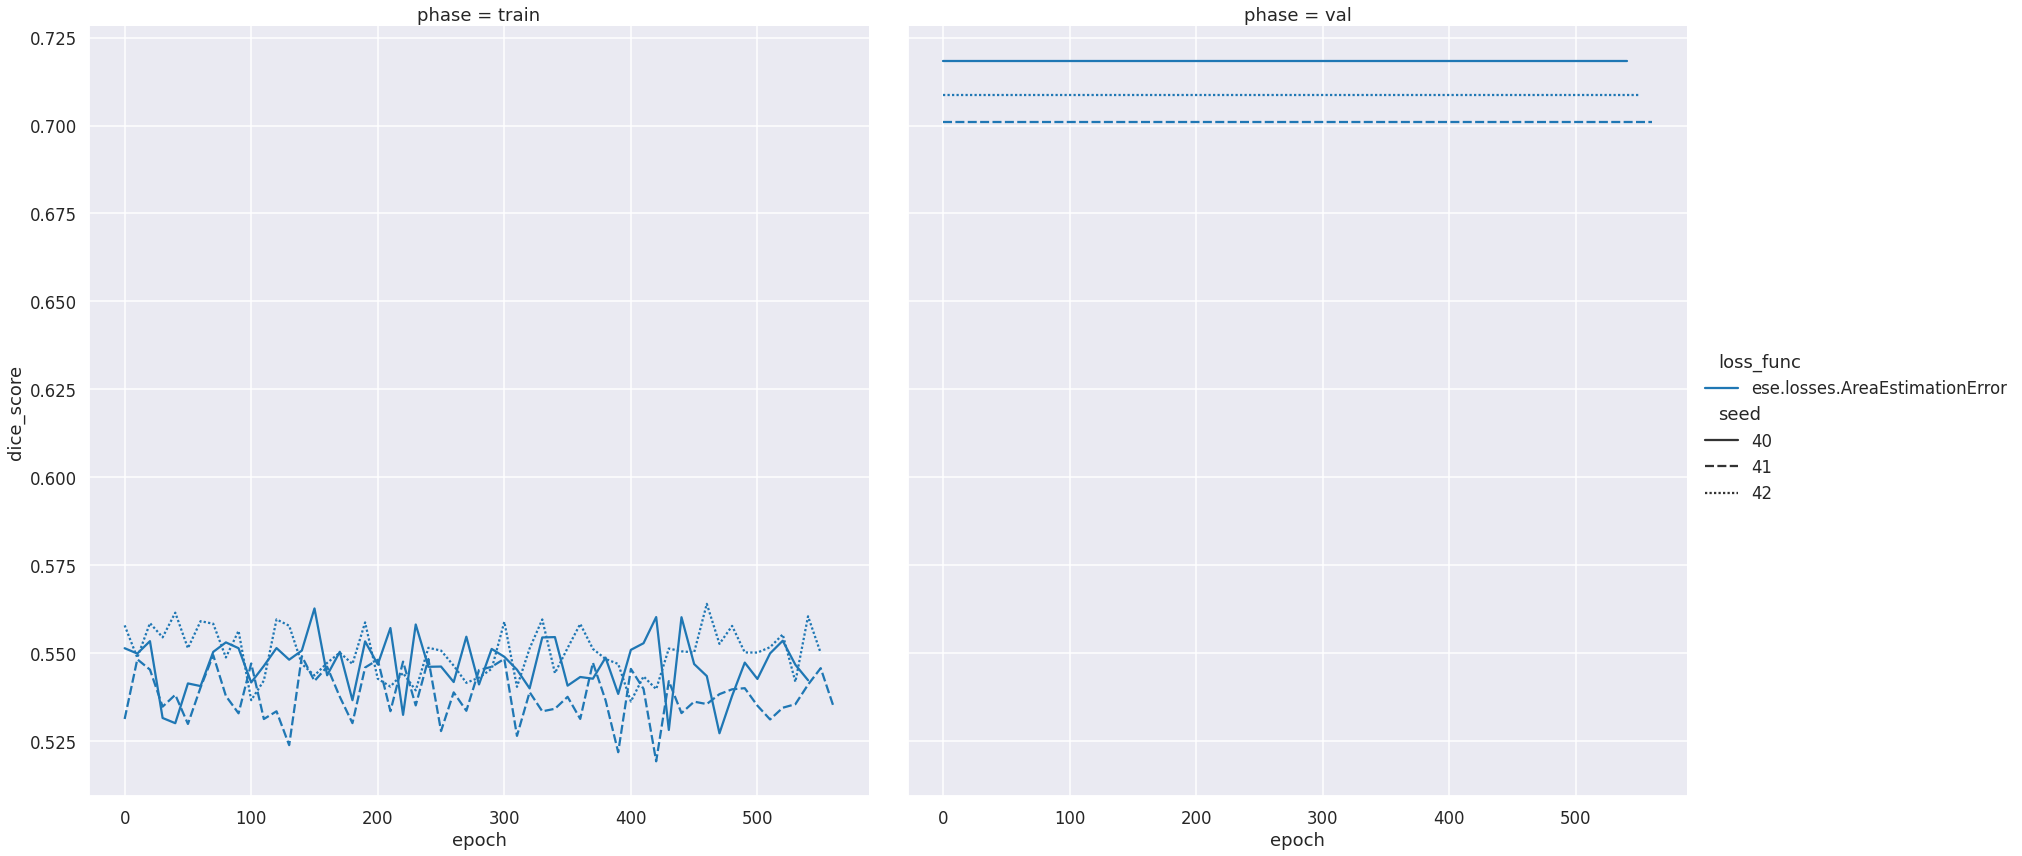

In [8]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='dice_score',
    hue='loss_func',
    style='seed',
    # hue='filters',
    # style='lr',
    col='phase',
    kind='line',
    height=12,
    # palette=custom_palette
)

# Set column spacing
g.fig.subplots_adjust(wspace=0.05)
# g.set(ylim=(0.0, 0.25))

In [9]:
# g = sns.relplot(
#     data=df,
#     x='epoch',
#     y='ece_loss',
#     hue='filters',
#     style='lr',   
#     row='loss_func',   
#     col='phase',
#     kind='line',
#     height=12,
#     # palette=custom_palette
# )

# # Set column spacing
# g.fig.subplots_adjust(wspace=0.05)
# # g.set(ylim=(0.0, 0.25))

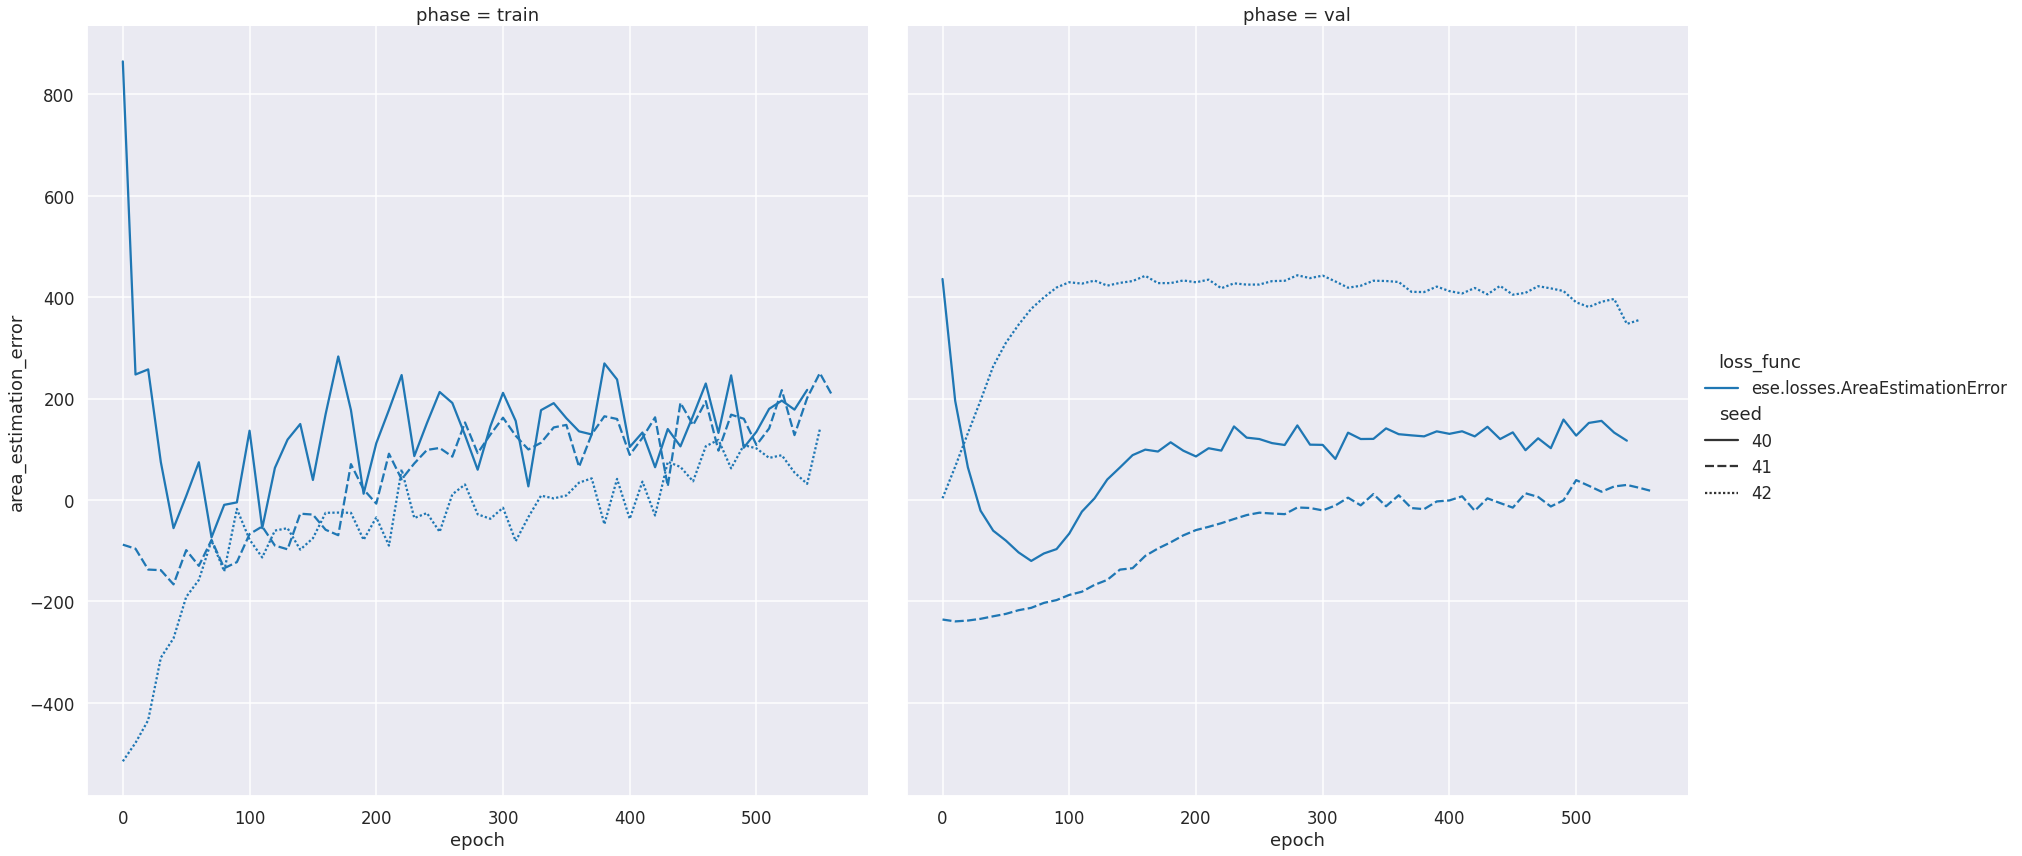

In [10]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='area_estimation_error',
    hue='loss_func',
    style='seed',
    # hue='filters',
    # style='lr',
    col='phase',
    kind='line',
    height=12,
    # palette=custom_palette
)

# Set column spacing
g.fig.subplots_adjust(wspace=0.05)
# g.set(ylim=(0.0, 0.25))

In [12]:
def aee_squared(area_estimation_error):
    return area_estimation_error**2

df.augment(aee_squared)

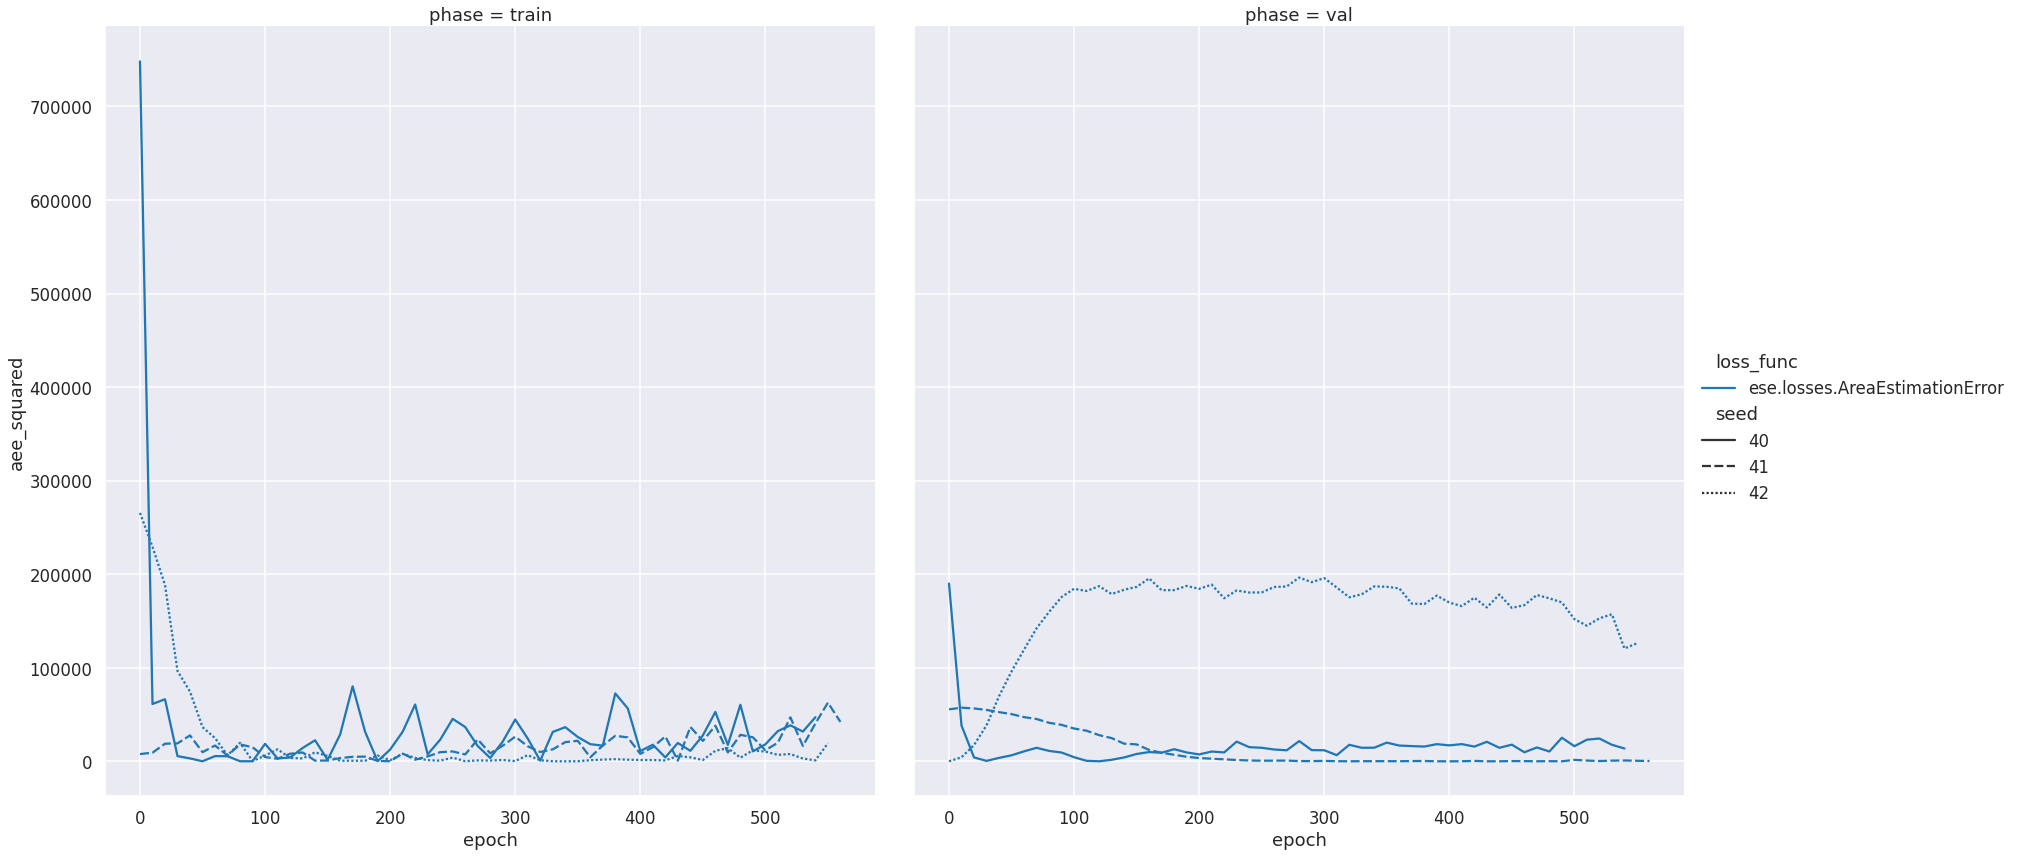

In [13]:
g = sns.relplot(
    data=df,
    x='epoch',
    y='aee_squared',
    hue='loss_func',
    style='seed',
    # hue='filters',
    # style='lr',
    col='phase',
    kind='line',
    height=12,
    # palette=custom_palette
)

# Set column spacing
g.fig.subplots_adjust(wspace=0.05)
# g.set(ylim=(0.0, 0.25))